In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import tree

import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
from IPython.core.display import display, HTML
# make the screen wider
display(HTML("<style>.container { width:100% !important; }</style>"))

# list themes
#!jt -l
# change theme
#!jt -t oceans16

In [3]:
# Load the csv files over here into pandas data frame
# YOUR CODE HERE
# 0.1
def load_csv(filename):
  # Input: csv_file_name
  # Output: pandas data frame
    return pd.read_csv(filename)

df = load_csv('./data/data.csv')
df.head()

,Id,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,81,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.00,3.8918,69.0,0.0
1,82,23.0,1.0,22.6,89.0,139.0,64.8,61.0,2.00,4.1897,68.0,0.0
2,83,66.0,2.0,26.2,114.0,255.0,185.0,56.0,4.55,4.2485,92.0,0.0
3,84,60.0,2.0,32.1,83.0,179.0,119.4,42.0,4.00,4.4773,94.0,0.0
4,85,29.0,1.0,30.0,85.0,180.0,93.4,43.0,4.00,5.3845,88.0,1.0


# 1 - Corelation  analysis

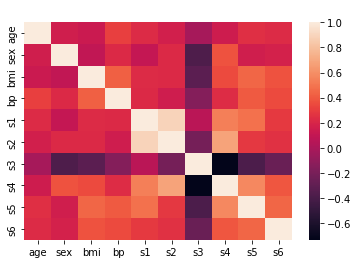

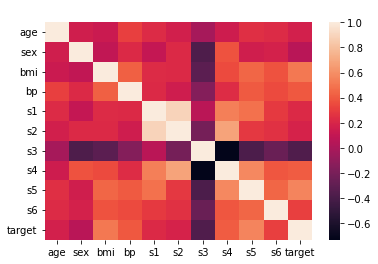

In [4]:
# The correlation matrix is the same as the one we discussed in class.
# HINT - If you are using a dataframe, then pandas.DataFrame.corr and sns.heatmap might be helpful.

# Print the corellation matrix here.
# YOUR CODE HERE
# 1.1
def correlationMatrix(target):
  # Include an option in the function to find correlation with/without the target variable
  # Output: A heatmap plot of the correlation matrix
  # Hint: Use the definition of correlation matrix to construct one for the features at hand
    id_ = df.pop('Id')
    if not target: 
        y = df.pop('target')
        corr = df.corr()
        df['target'] = y
    else:
        corr = df.corr()
    df['Id'] = id_
    hmp = sns.heatmap(corr)
    
    return hmp 

# 1.2
# Plot both the heat maps for correlation among just features and one including the target variable
correlationMatrix(False)
plt.title('Heatmap without target', color='white')
plt.show()

correlationMatrix(True)
plt.title('Heatmap with target', color='white')
plt.show()


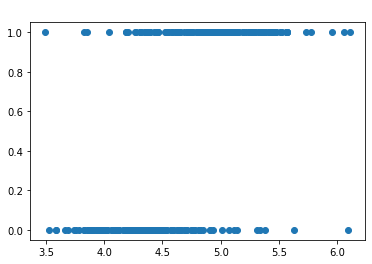

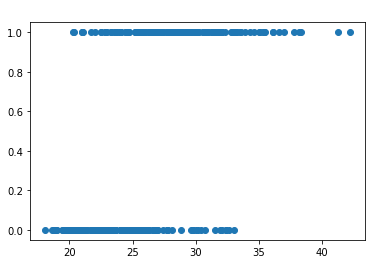

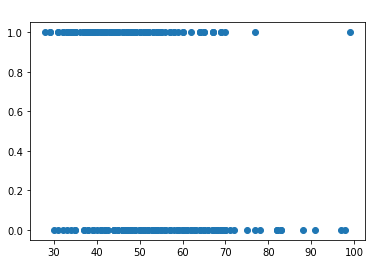

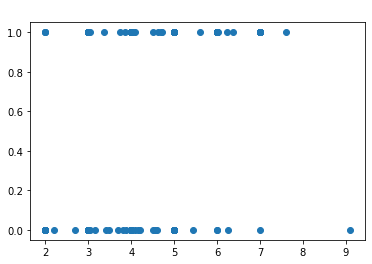

In [5]:
# 1.3
'''Scatter Plots between features: s5, bmi, bp, s4 and the target column'''

# Use the target as a constant y var
y = df['target']

# Generate Scatter Plot for s5 vs target
x = df['s5']
plt.scatter(x,y)
plt.title('s5 vs target - Scatter Plot', color='white')
plt.show()

# Generate Scatter Plot for bmi vs target
x = df['bmi']
plt.scatter(x,y)
plt.title('bmi vs target - Scatter Plot', color='white')
plt.show()

# Generate Scatter Plot for bp vs target
x = df['s3']
plt.scatter(x,y)
plt.title('s3 vs target - Scatter Plot', color='white')
plt.show()

# Generate Scatter Plot for s4 vs target
x = df['s4']
plt.scatter(x,y)
plt.title('s4 vs target - Scatter Plot', color='white')
plt.show()

# Data normalization and cleaning

In [ ]:
'''
Check for NaNs in the data, since there arent any I didnt remove any. 
Remove outliers with the below thresholds
'''
# Take all the features as input, and do any data cleaning necessary.
def cleaning(df):
    #make a copy of the dataframe to manipulate
    df2 = df.copy()
    # get column names
    cols = list(df2.columns.values)

    # check for NaN values
    nans = df2.isna().any()
    if nans.all() == False: print('No NaN entries')
    
    for c in cols: 
        if (not c == 'Id') & (not c == 'age') & (not c == 'sex') & (not c == 'target'):
            # define the 1st and 3rd quartiles
            q1 = df2[c].quantile(0.25)
            q3 = df2[c].quantile(0.75)
            inter_quart = q3 - q1
            #remove outliers per this formula
            min_thresh = q1 - 1.5*inter_quart
            max_thresh = q3 + 1.5*inter_quart
            #iterate df and remove the samples that are outliers
            df2 = df2.loc[(df2[c] > min_thresh) & (df2[c] < max_thresh)]
    
    # return the modified df
    return df2

# run data through the cleaning function to remove outliers
df_clean = cleaning(df)
cols = list(df_clean.columns.values)

#plot the histograms of the values
for c in cols: 
    if (not c == 'Id') & (not c == 'age') & (not c == 'sex') & (not c == 'target'):
        df_clean.hist(column=c, bins=20, grid=False)


In [6]:
# Taken input the output of cleaning function, and perform data normalization independently for all the features.
def normalizer(df_in, train=True):
    df_temp = df_in.copy(deep=True)
    # get column names into a mutable list
    cols = list(df_temp.columns.values)
    
    #remove id and target
    id_ = df_temp.pop('Id')
    if train:
        target_ = df_temp.pop('target').values
    
    # normalize using sklearn preprocessing normalize method and convert to df
    if train: df_norm = pd.DataFrame(normalize(df_temp), columns=cols[1:-1])
    else: df_norm = pd.DataFrame(normalize(df_temp), columns=cols[1:])
    # add the target column back into the dataframe
    if train:
        df_norm['target'] = target_
    else:
        df_norm['Id'] = id_
    
    return df_norm

# normed dataframe
X = normalizer(df, True)

#prepare for train test split
y = X.pop('target')

# 2 - Model training and testing

In [15]:
# Splitting the dataset into train, val and test sets.
# 2.0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=106)

In [16]:
# 2.1
# You can use the LR sci-kit learn solver but capture any other hyper-parameter settings or model settings in this method
def LogisticRegression_(c, auc=False, kaggle=False):
    LR_model = LogisticRegression(max_iter=300, l1_ratio=0.4, penalty='elasticnet', C=c, solver='saga', random_state=74).fit(X_train, y_train)
    if kaggle:
        if auc: return LR_model.predict_proba(X_test)
        else: return LR_model.predict(X_test)
    else:
        if auc: # if we are needing to alter threshold for part 5
            y_train_pred_LR = LR_model.predict_proba(X_train) # predict_proba returns nx2 vector of probabilities for class 0 and 1
            y_val_pred_LR = LR_model.predict_proba(X_val)
        else:
            y_train_pred_LR = LR_model.predict(X_train)
            y_val_pred_LR = LR_model.predict(X_val)
        return y_train_pred_LR, y_val_pred_LR, LR_model

# 2.2
def DecisionTree(auc=False, kaggle=False):
    DT_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=54).fit(X_train,y_train)
    if kaggle:
        return DT_model.predict(X_test)
    else:
        if auc: # if we are needing to alter threshold for part 5
            y_train_pred_DT = DT_model.predict_proba(X_train)
            y_val_pred_DT = DT_model.predict_proba(X_val)
        else:
            y_train_pred_DT = DT_model.predict(X_train)
            y_val_pred_DT = DT_model.predict(X_val)
        return y_train_pred_DT, y_val_pred_DT, DT_model

In [17]:
# Create function which calculates F1score, precision, recall and accuracy score for true and predicted labels.
# 2.3
def metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    print(f'F1 Score: {f1}')
    print(f'Accuracy Score: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print()

In [21]:
y_train_pred_LR, y_val_pred_LR, LR_model = LogisticRegression_(67, auc=True)
y_val_proba = np.delete(y_val_pred_LR,0,axis=1)
y_train_proba = np.delete(y_train_pred_LR,0,axis=1)

y_pred_val, y_pred_train = [],[]
thresh = 0.4350
for prob in y_val_proba:
    if prob >= thresh: y_pred_val.append(1.0)
    else: y_pred_val.append(0.0)
for prob in y_train_proba:
    if prob >= thresh: y_pred_train.append(1.0)
    else: y_pred_train.append(0.0)
print('Train Metrics -- LR')
metrics(y_pred_train, y_train)
print('Validation Metrics -- LR')
metrics(y_pred_val, y_val)

y_train_pred_DT, y_val_pred_DT, DT_model = DecisionTree()
print('Train Metrics -- DT')
metrics(y_train_pred_DT, y_train)
print('Validation Metrics -- DT')
metrics(y_val_pred_DT, y_val)

Train Metrics -- LR
F1 Score: 0.763779527559055
Accuracy Score: 0.7402597402597403
Precision: 0.7028985507246377
Recall: 0.8362068965517241

Validation Metrics -- LR
F1 Score: 0.8620689655172413
Accuracy Score: 0.8620689655172413
Precision: 0.8333333333333334
Recall: 0.8928571428571429

Train Metrics -- DT
F1 Score: 0.8617886178861788
Accuracy Score: 0.8528138528138528
Precision: 0.8153846153846154
Recall: 0.9137931034482759

Validation Metrics -- DT
F1 Score: 0.7666666666666666
Accuracy Score: 0.7586206896551724
Precision: 0.71875
Recall: 0.8214285714285714



seed: 106
train f1: 0.7542372881355933
val f1: 0.9019607843137255


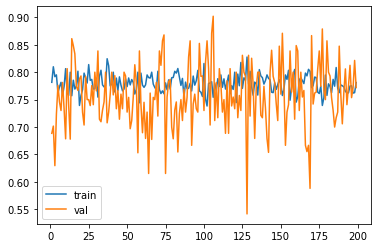

In [14]:
'''Attempt to find the best seed based on damping value'''
# seed search
seeds = np.arange(1,200,1)
train_f1s, val_f1s = [], []
for seed in seeds:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=seed)
    y_train_pred_LR, y_val_pred_LR, _ = LogisticRegression_(67)
    train_f1s.append(f1_score(y_train, y_train_pred_LR))
    val_f1s.append(f1_score(y_val, y_val_pred_LR))

max_ = np.argmax(val_f1s)
print('seed:', seeds[max_])
print('train f1:',train_f1s[max_])
print('val f1:', val_f1s[max_])
    
plt.plot(seeds, train_f1s, label='train')
plt.plot(seeds, val_f1s, label='val')
plt.legend()
plt.show()

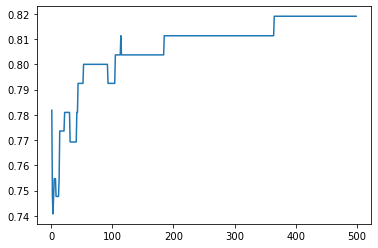

c: 365 
f1: 0.8190476190476189


In [12]:
'''
Attempt to find the best damping value based on current seed value
'''
# generate range of values
c_values = np.arange(1,500,1)
# var to hold f1 scores
f1s = []

# iterate the possible c values and test with LR model by running through f1 metric
for c in c_values:
    _, y_val_pred_LR, _ = LogisticRegression_(c)
    f1s.append(f1_score(y_val, y_val_pred_LR))

# plot the curve for visual explanation
plt.plot(c_values, f1s)
plt.show()

# get max f1 index and print corresponding c and f1 value
max_f1 = np.argmax(f1s)
print('c:', c_values[max_f1], '\nf1:', f1s[max_f1])

Max val f1:  0.90196 at thresh  0.5000
Train f1  0.75424


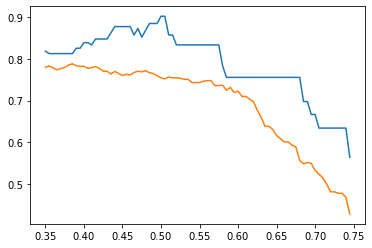

In [19]:
y_train_proba, y_val_proba, _ = LogisticRegression_(67, auc=True)
y_val_proba = np.delete(y_val_proba,0,axis=1)
y_train_proba = np.delete(y_train_proba,0,axis=1)

threshs = np.arange(.35,.75,0.005)
train_f1s, val_f1s = [], []
for thresh in threshs:
    y_pred = []
    for prob in y_val_proba:
        if prob >= thresh: y_pred.append(1.0)
        else: y_pred.append(0.0)
    val_f1s.append(f1_score(y_val, y_pred))
    
    y_pred = []
    for prob in y_train_proba:
        if prob >= thresh: y_pred.append(1.0)
        else: y_pred.append(0.0)
    train_f1s.append(f1_score(y_train, y_pred))

max_ = np.argmax(val_f1s)
print(f'Max val f1: {val_f1s[max_]: .5f} at thresh {threshs[max_]: .4f}')
print(f'Train f1 {train_f1s[max_]: .5f}')
    
plt.plot(threshs, val_f1s)
plt.plot(threshs, train_f1s)
plt.show()

## 2b -  Kaggle Test Data

In [ ]:
'''
Perform predictions on test data
'''
# load the kaggle data into notebook
df_kaggle = load_csv('./data/kaggle.csv')
# normalize data with the same method as used for training -- dont clean
X_test = normalizer(df_kaggle, False)
# remove the id column before passing to LR function
id_ = X_test.pop('Id')
#X_test.pop('age')
#X_test.pop('sex')
#X_test.pop('s1')
# predict with LR
y_test_pred_LR = LogisticRegression_(67, auc=True, kaggle=True)
#y_test_pred_LR = DecisionTree(kaggle=True)
y_test_proba = np.delete(y_test_pred_LR,0,axis=1)
y_pred_test = []
thresh = 0.4350
for prob in y_test_proba:
    if prob >= thresh: y_pred_test.append(1.0)
    else: y_pred_test.append(0.0)
# prepare data for export 
out_data = {
    'Id' : (id_),
    'Predicted' : (y_pred_test)
}
# convert data dictionary to dataframe
out_df = pd.DataFrame(out_data, index=None)
# export
out_df.to_csv('./preds_test.csv')

# 3 - Feature importance

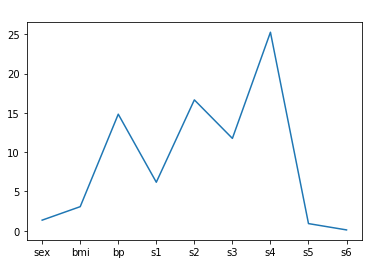

The top 5 features for the LR model are ['s4', 's2', 'bp', 's3', 's1']


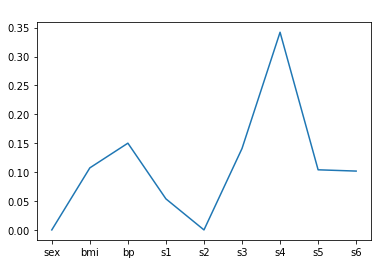

The top 5 features for the DT model are ['s4', 'bp', 's3', 'bmi', 's5']


In [20]:
# Look into using suitable functions from sklearn. Explain your code and findings clearly in the report document.
# YOUR CODE HERE
# 3.1
def FeatureSelection(k, model='LR'):
    if model == 'LR':
        # get the parameter weights and columns names
        coefs = list(abs(LR_model.coef_[0])) # abs so they can be compared
    elif model == 'DT':
        # feature importance function returns unsorted list of feature importances
        coefs = list(DT_model.feature_importances_)

    cols = list(X_train.columns.values)
    #print(coefs,'\n',cols)
    # iterate the coefs and sort the columns in descending importance of feature weight
    sorted_cols = []
    for i in range(len(coefs)-1):
        max_ = np.argmax(coefs) #get the highest value weight
        coefs.pop(max_) # pop the coef value
        sorted_cols.append(cols.pop(max_)) # pop the column name and append to the sorted columns list
    
    # generate new coef and cols to plot the weight per feature plot
    if model == 'LR': coefs = list(abs(LR_model.coef_[0]))
    elif model == 'DT': coefs = DT_model.feature_importances_
    cols = list(X_train.columns.values)
    plt.plot(cols, coefs)
    plt.title('Features vs Absolute Value of Feature Weight', color='white')
    plt.show()
    
    return sorted_cols[:k] # return the top k features
  # Your code can based on measures of information gain or other feature selection methods
  # Input: k - Number of features to pick
  # Output should be a ranked list of features

k=5
models = ['LR', 'DT']
for m in models:
    features = FeatureSelection(k, model=m)
    print(f'The top {k} features for the {m} model are {features}')
# 3.2 Do the features identified by information gain measures in the FeatureSelection correlate with your model weights for LR/ top features in your Decision Tree model?

# 4 - Analyzing few positive and negative examples

In [22]:
# Get few predictions from the trained decision tree model.
# YOUR CODE HERE
# 4.1

# Helper function to check if random number was already selected
def exists(arr, num):
    for a in arr:
        if a == num: return True
    return False

def ModelIntepretability(DT_model):
    # Input: Decision Tree Model 
    # Output: An explanation based on the decision tree model for 3-4 randomly selected positive and negative examples.
    # Hint: For any given example, walk through the decision tree from the root to the prediction and write code to automatically construct a sentence to explain the same.

    # store the key features, thresholds and ids of left and right children from the DT model
    thresholds = DT_model.tree_.threshold
    features = DT_model.tree_.feature
    left_children = DT_model.tree_.children_left
    right_children = DT_model.tree_.children_right
    
    # store the column names to be used in the description of the decisions
    col_names = X_val.columns.values

    # get positive and negative dataframes to guarantee a postive and negative sample selection
    pos_val = X_val[y_val == 1]
    neg_val = X_val[y_val == 0]

    # get the index values of the samples so properly index the arrays with random indexes
    pos_idxs = pos_val.index.values
    neg_idxs = neg_val.index.values
    
    sample_idxs = []
    # get 3 samples of positive outcome and 3 samples of negative outcome
    for i in range(6):
        if i <= 2: # 3 positive samples
            num = pos_idxs[random.randrange(0,len(pos_idxs))] # random number between 0 and the length of the indices, which is used as the index for positive indices
            while exists(sample_idxs, num) : num = pos_idxs[random.randrange(0,len(pos_idxs))] # if the number has already been chosen, chose another random number
            sample_idxs.append(num) # append after finding a number that hasnt already been chosen
        else: #  and 3 negative samples
            num = neg_idxs[random.randrange(0,len(neg_idxs))] 
            while exists(sample_idxs, num) : num = neg_idxs[random.randrange(0,len(neg_idxs))]
            sample_idxs.append(num) # store randomly chosen negative indices
    
    for i,s_idx in enumerate(sample_idxs):
        sample = np.array(X_val[X_val.index.values == s_idx]).reshape(1,-1) # using the random indices, get the sample of each index
        path = DT_model.decision_path(sample) # call the decision_path function which returns the path that was taken to get to the end result
        node_ids = path.indices # get the actual node ids of the path taken
        print(f'Path for predicting sample {i} with dataframe index {s_idx}')
        path_len = len(node_ids)
        # Describe the path
        for j, step in enumerate(node_ids):
            if j < path_len - 1: # if not leaf node
                value = sample[0][features[step]] # feature value to split on
                if value > thresholds[step]: direction = 'right' # decision to go left or right down the tree
                else: direction = 'left'
                # print the result for this decision
                print(f'Decision at node {node_ids[j]}: split on {col_names[features[step]]} with threshold {thresholds[step]: .3f}. The feature value at this split is {value: .3f}, so the {direction} path is taken.')
            else:
                ground_truth = y_val[y_val.index.values == s_idx].values[0]
                pred = DT_model.predict(sample)[0]
                if ground_truth == pred: correct = ' correct'
                else: correct = 'n incorrect'
                print(f'Leaf node reached! The DT predicted {pred} and the true value was {ground_truth} so it was a{correct} prediction!')
        print()
        

ModelIntepretability(DT_model)        

# 4.2
# Also, for the report - Discuss any patterns or insights you notice when you look at explaining the positive/negative examples above.

Path for predicting sample 0 with dataframe index 124
Decision at node 0: split on s4 with threshold  0.155. The feature value at this split is  0.143, so the left path is taken.
Decision at node 1: split on s5 with threshold  0.018. The feature value at this split is  0.019, so the right path is taken.
Decision at node 9: split on bmi with threshold  0.004. The feature value at this split is  0.004, so the left path is taken.
Leaf node reached! The DT predicted 1.0 and the true value was 1.0 so it was a correct prediction!

Path for predicting sample 1 with dataframe index 182
Decision at node 0: split on s4 with threshold  0.155. The feature value at this split is  0.151, so the left path is taken.
Decision at node 1: split on s5 with threshold  0.018. The feature value at this split is  0.014, so the left path is taken.
Decision at node 2: split on bmi with threshold  0.008. The feature value at this split is  0.003, so the left path is taken.
Decision at node 3: split on s3 with th

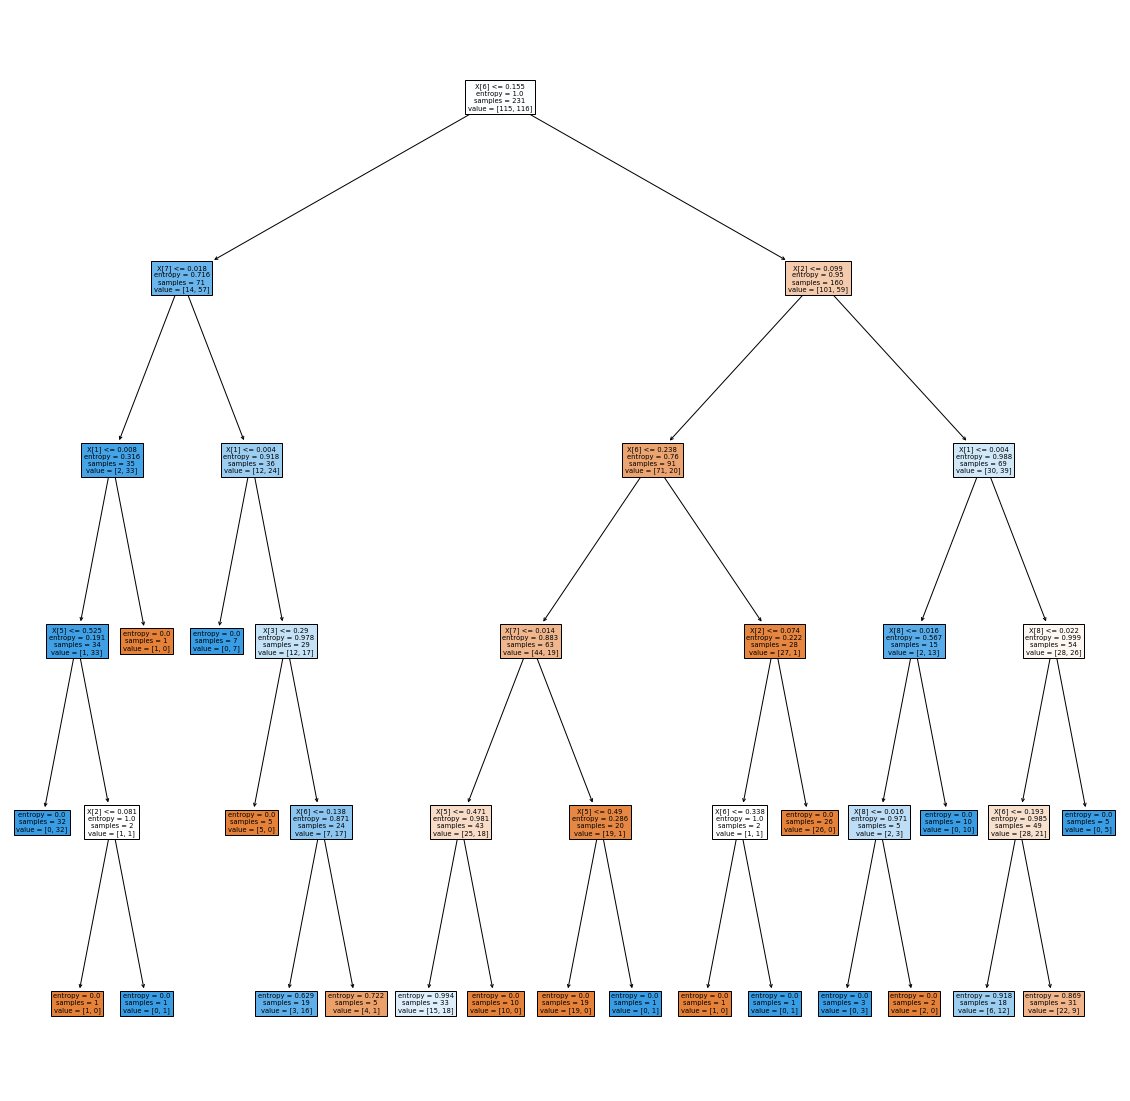

In [23]:
_, axs = plt.subplots(figsize=(20,20)) 
tree.plot_tree(DT_model, filled=True, ax=axs)
plt.show()

# 5 - AUC for both the models

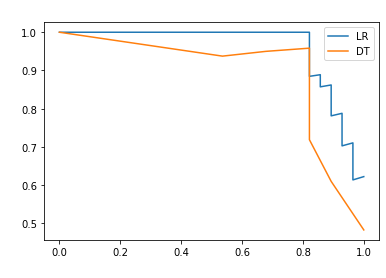

In [34]:
# Plot the F1score for different threshold values for both the models on the same graph.

def PlotF1AUC():
    _, y_val_proba, _ = LogisticRegression_(67, auc=True)
    precision, recall, thresholds = precision_recall_curve(y_val, np.delete(y_val_proba,0,axis=1))
    plt.plot(recall, precision, label='LR')
    
    _, y_val_proba, _ = DecisionTree(auc=True)
    precision, recall, thresholds = precision_recall_curve(y_val, np.delete(y_val_proba,0,axis=1))
    #print(recall, precision, thresholds)
    plt.plot(recall, precision, label='DT')
    
    plt.xlabel('Recall', color='white')
    plt.ylabel('Precision', color='white')
    plt.legend()
    plt.title('Precision-Recall Curve Logisitic Regression', color='white')
    plt.show()
    
    
PlotF1AUC()